In [3]:
# Import dependencies

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import gmaps
import os
import json
import scipy.stats as st
from scipy.stats import linregress

# Import API key
from config import gkey

In [4]:
# Convert Johns Hopkins covid dataset to Pandas DataFrame

file = "data/1_county_level_confirmed_cases.csv"
original_df = pd.read_csv(file)
covid_df = original_df.dropna(subset=["confirmed_per_100000", "deaths_per_100000"])

covid_df.head()

,last_update,location_type,state,county_name,county_name_long,fips_code,lat,lon,NCHS_urbanization,total_population,confirmed,confirmed_per_100000,deaths,deaths_per_100000
0,2020-09-23 23:23:49 UTC,county,Alabama,Autauga,"Autauga, Alabama, US",1001.0,32.539527,-86.644082,Medium metro,55200.0,1715,3106.88,25,45.29
1,2020-09-23 23:23:49 UTC,county,Alabama,Baldwin,"Baldwin, Alabama, US",1003.0,30.727750,-87.722071,Small metro,208107.0,5141,2470.36,49,23.55
2,2020-09-23 23:23:49 UTC,county,Alabama,Barbour,"Barbour, Alabama, US",1005.0,31.868263,-85.387129,Non-core,25782.0,851,3300.75,7,27.15
3,2020-09-23 23:23:49 UTC,county,Alabama,Bibb,"Bibb, Alabama, US",1007.0,32.996421,-87.125115,Large fringe metro,22527.0,638,2832.16,10,44.39
4,2020-09-23 23:23:49 UTC,county,Alabama,Blount,"Blount, Alabama, US",1009.0,33.982109,-86.567906,Large fringe metro,57645.0,1580,2740.91,15,26.02


In [5]:
# Convert presidential election results dataset to Pandas DataFrame

file2 = "data/countypres_2000-2016.csv"
election_df = pd.read_csv(file2)
election_df.head()

,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version
0,2000,Alabama,AL,Autauga,1001.0,President,Al Gore,democrat,4942.0,17208,20191203
1,2000,Alabama,AL,Autauga,1001.0,President,George W. Bush,republican,11993.0,17208,20191203
2,2000,Alabama,AL,Autauga,1001.0,President,Ralph Nader,green,160.0,17208,20191203
3,2000,Alabama,AL,Autauga,1001.0,President,Other,NaN,113.0,17208,20191203
4,2000,Alabama,AL,Baldwin,1003.0,President,Al Gore,democrat,13997.0,56480,20191203


In [6]:
# Limit election DataFrame to most recent presidential election only (2016)
clean_election_df = election_df.loc[election_df["year"] == 2016]

# Create a new colum with the % of the vote that the candidate received
clean_election_df["candidate_pcnt"] = clean_election_df["candidatevotes"] / clean_election_df["totalvotes"]

# Create a new column that combines the county name, state name, and country (US)
clean_election_df["county_name_long"] = clean_election_df["county"] + ", " + clean_election_df["state"] + ", US"

# Grab only the columns that we are interested in
clean_election_df = clean_election_df[["county_name_long", "candidate", "candidate_pcnt"]]

C:\Users\mcogg\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\mcogg\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
# View DataFrame
clean_election_df.head()

,county_name_long,candidate,candidate_pcnt
40517,"Autauga, Alabama, US",Hillary Clinton,0.237697
40518,"Autauga, Alabama, US",Donald Trump,0.727666
40519,"Autauga, Alabama, US",Other,0.034637
40520,"Baldwin, Alabama, US",Hillary Clinton,0.193856
40521,"Baldwin, Alabama, US",Donald Trump,0.765457


In [8]:
# Create a new DataFrame looking at Clinton resuls only

clinton_df = clean_election_df.loc[clean_election_df["candidate"] == "Hillary Clinton"]
clinton_df = clinton_df.rename(columns={"candidate_pcnt": "Hillary Clinton"})
clinton_df.head()

,county_name_long,candidate,Hillary Clinton
40517,"Autauga, Alabama, US",Hillary Clinton,0.237697
40520,"Baldwin, Alabama, US",Hillary Clinton,0.193856
40523,"Barbour, Alabama, US",Hillary Clinton,0.465278
40526,"Bibb, Alabama, US",Hillary Clinton,0.212496
40529,"Blount, Alabama, US",Hillary Clinton,0.084258


In [9]:
# Create a new DataFrame looking at Trump results only

trump_df = clean_election_df.loc[clean_election_df["candidate"] == "Donald Trump"]
trump_df = trump_df.rename(columns={"candidate_pcnt": "Donald Trump"})
trump_df.head()

,county_name_long,candidate,Donald Trump
40518,"Autauga, Alabama, US",Donald Trump,0.727666
40521,"Baldwin, Alabama, US",Donald Trump,0.765457
40524,"Barbour, Alabama, US",Donald Trump,0.520967
40527,"Bibb, Alabama, US",Donald Trump,0.764032
40530,"Blount, Alabama, US",Donald Trump,0.893348


In [10]:
# Create a new DataFrame looking at Other reults only
other_df = clean_election_df.loc[clean_election_df["candidate"] == "Other"]
other_df = other_df.rename(columns={"candidate_pcnt": "Other"})
other_df.head()

,county_name_long,candidate,Other
40519,"Autauga, Alabama, US",Other,0.034637
40522,"Baldwin, Alabama, US",Other,0.040687
40525,"Barbour, Alabama, US",Other,0.013755
40528,"Bibb, Alabama, US",Other,0.023472
40531,"Blount, Alabama, US",Other,0.022393


In [11]:
# Merge the election results DataFrames and rename columns
merge_df = pd.merge(clinton_df, trump_df, on=["county_name_long"])
merge_df = pd.merge(merge_df, other_df, on=["county_name_long"])
merge_df = merge_df.drop(columns=["candidate_x", "candidate_y", "candidate"])
merge_df = merge_df.set_index("county_name_long")
merge_df = merge_df.dropna(how="any")
merge_df.head()

,Hillary Clinton,Donald Trump,Other
county_name_long,,,
"Autauga, Alabama, US",0.237697,0.727666,0.034637
"Baldwin, Alabama, US",0.193856,0.765457,0.040687
"Barbour, Alabama, US",0.465278,0.520967,0.013755
"Bibb, Alabama, US",0.212496,0.764032,0.023472
"Blount, Alabama, US",0.084258,0.893348,0.022393


In [12]:
# Create a new column showing the winner for each county
merge_df["Winner"] = merge_df.idxmax(axis=1)

# Create a new column showing the vote margin
# Positive values indicate a win for Trump
# Negative values indiciate a win for Clinton
merge_df["Trump Margin"] = (merge_df["Donald Trump"] - merge_df["Hillary Clinton"]) * 100

# Rename the columns in the DataFrame
merge_df = merge_df.rename(columns={"Hillary Clinton": "Hillary Clinton (%)",
                                   "Donald Trump": "Donald Trump (%)",
                                   "Other": "Other (%)"})

#Display the DataFrame
merge_df

,Hillary Clinton (%),Donald Trump (%),Other (%),Winner,Trump Margin
county_name_long,,,,,
"Autauga, Alabama, US",0.237697,0.727666,0.034637,Donald Trump,48.996917
"Baldwin, Alabama, US",0.193856,0.765457,0.040687,Donald Trump,57.160111
"Barbour, Alabama, US",0.465278,0.520967,0.013755,Donald Trump,5.568822
"Bibb, Alabama, US",0.212496,0.764032,0.023472,Donald Trump,55.153646
"Blount, Alabama, US",0.084258,0.893348,0.022393,Donald Trump,80.909020
...,...,...,...,...,...
"District 37, Alaska, US",0.478269,0.382853,0.138878,Hillary Clinton,-9.541683
"District 38, Alaska, US",0.541315,0.224338,0.234347,Hillary Clinton,-31.697743
"District 39, Alaska, US",0.557191,0.249158,0.193651,Hillary Clinton,-30.803334


In [13]:
# Merge the covid DataFrame with the cleaned election DataFrame
covid_election_df = pd.merge(covid_df, merge_df, on=["county_name_long"])
covid_election_df.head()

,last_update,location_type,state,county_name,county_name_long,fips_code,lat,lon,NCHS_urbanization,total_population,confirmed,confirmed_per_100000,deaths,deaths_per_100000,Hillary Clinton (%),Donald Trump (%),Other (%),Winner,Trump Margin
0,2020-09-23 23:23:49 UTC,county,Alabama,Autauga,"Autauga, Alabama, US",1001.0,32.539527,-86.644082,Medium metro,55200.0,1715,3106.88,25,45.29,0.237697,0.727666,0.034637,Donald Trump,48.996917
1,2020-09-23 23:23:49 UTC,county,Alabama,Baldwin,"Baldwin, Alabama, US",1003.0,30.727750,-87.722071,Small metro,208107.0,5141,2470.36,49,23.55,0.193856,0.765457,0.040687,Donald Trump,57.160111
2,2020-09-23 23:23:49 UTC,county,Alabama,Barbour,"Barbour, Alabama, US",1005.0,31.868263,-85.387129,Non-core,25782.0,851,3300.75,7,27.15,0.465278,0.520967,0.013755,Donald Trump,5.568822
3,2020-09-23 23:23:49 UTC,county,Alabama,Bibb,"Bibb, Alabama, US",1007.0,32.996421,-87.125115,Large fringe metro,22527.0,638,2832.16,10,44.39,0.212496,0.764032,0.023472,Donald Trump,55.153646
4,2020-09-23 23:23:49 UTC,county,Alabama,Blount,"Blount, Alabama, US",1009.0,33.982109,-86.567906,Large fringe metro,57645.0,1580,2740.91,15,26.02,0.084258,0.893348,0.022393,Donald Trump,80.909020


In [14]:
# Create new DataFrames to split out red counties and blue counties
red_counties_df = covid_election_df.loc[covid_election_df["Winner"] == "Donald Trump"]
blue_counties_df = covid_election_df.loc[covid_election_df["Winner"] == "Hillary Clinton"]

In [15]:
# Configure gmaps with API key
gmaps.configure(api_key = gkey)

In [16]:
# Create heatmap looking at confirmed cases per 100000 in all counties across the country

# Store coordinates into  locations 
locations = covid_election_df[["lat", "lon"]].astype(float)

# Store confirmed cases per 1000000 as float
cases = covid_election_df["confirmed_per_100000"].astype(float)

# Create heatmap
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=cases,
                                 dissipating=False, max_intensity=max(cases),
                                 point_radius = 1)

heat_layer.gradient = ["white", "black"]
fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [17]:
# Create heatmap looking at confirmed cases per 100000 in red counties only

# Store coordinates into  locations 
red_locations = red_counties_df[["lat", "lon"]].astype(float)

# Store confirmed cases per 1000000 as float
red_cases = red_counties_df["confirmed_per_100000"].astype(float)

# Create heatmap
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(red_locations, weights=red_cases,
                                 dissipating=False, max_intensity=max(cases),
                                 point_radius = 1)

heat_layer.gradient = ["white", "red"]
fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [18]:
# Create heatmap looking at confirmed cases per 100000 in blue counties only

# Store coordinates into  locations 
blue_locations = blue_counties_df[["lat", "lon"]].astype(float)

# Store confirmed cases per 1000000 as float
blue_cases = blue_counties_df["confirmed_per_100000"].astype(float)

# Create heatmap
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(blue_locations, weights=blue_cases,
                                 dissipating=False, max_intensity=max(cases),
                                 point_radius = 1)

heat_layer.gradient = ["white", "blue"]
fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [19]:
# Compare average population in red counties vs. blue counties

print(red_counties_df["total_population"].mean())
print(blue_counties_df["total_population"].mean())

55936.142254601225
366621.41046277666


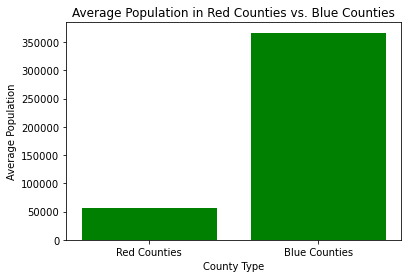

In [20]:
# Create a bar chart showing average population in red counties vs. blue counties

average_pop = [55936, 366621]
county_type = ["Red Counties", "Blue Counties"]
x_axis = np.arange(len(county_type))
plt.bar(x_axis, average_pop, color="g", align="center")
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, county_type)

plt.title("Average Population in Red Counties vs. Blue Counties")
plt.xlabel("County Type")
plt.ylabel("Average Population")

plt.savefig("Images/Average Population in Red Counties vs. Blue Counties.png")

In [21]:
# Check how many counties each candidate won
county_df = covid_election_df["Winner"].value_counts()
county_df

Donald Trump       2608
Hillary Clinton     497
Name: Winner, dtype: int64

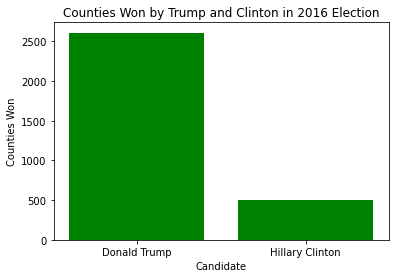

In [22]:
# Create a bar chart showing counties won by each candidate
winners = ["Donald Trump", "Hillary Clinton"]
counties = [2608, 497]
x_axis = np.arange(len(counties))
plt.bar(x_axis, counties, color="g", align="center")
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, winners)

plt.title("Counties Won by Trump and Clinton in 2016 Election")
plt.xlabel("Candidate")
plt.ylabel("Counties Won")

plt.savefig("Images/Counties Won by Trump and Clinton in 2016 Election.png")

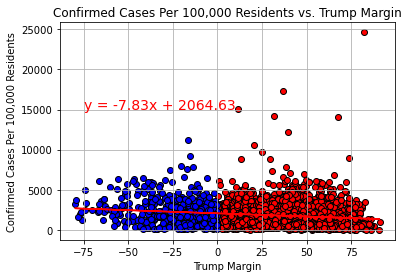

The r-value is -0.16458302217126783
The p-value is 2.6987853859125615e-20


In [23]:
# Evaluate whether there is a relationship between confirmed cases per 100000 residents vs. margin Trump won/lost by

# Calculate linear regression model
x_values = covid_election_df["Trump Margin"]
y_values = covid_election_df["confirmed_per_100000"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot Trump margin against confirmed cases per 100000
# Annotate with linear regression equation
plt.scatter(red_counties_df["Trump Margin"], red_counties_df["confirmed_per_100000"], marker="o", facecolors="red", 
            edgecolors="black")
plt.scatter(blue_counties_df["Trump Margin"], blue_counties_df["confirmed_per_100000"], marker="o", facecolors="blue", 
            edgecolors="black")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq, (-75, 15000), fontsize=14,color="red")
plt.grid()
plt.xlabel("Trump Margin")
plt.ylabel("Confirmed Cases Per 100,000 Residents")
plt.title("Confirmed Cases Per 100,000 Residents vs. Trump Margin")
plt.savefig("Images/Confirmed Cases Per 100,000 Residents vs. Trump Margin.png")
plt.show()
print(f"The r-value is {rvalue}")
print(f"The p-value is {pvalue}")


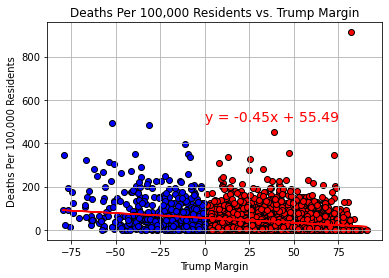

The r-value is -0.2551017821156189
The p-value is 2.5473821879783344e-47


In [24]:
# Evaluate whether there is a relationship between deaths per 100000 residents vs. margin Trump won/lost by

# Calculate linear regression model
x_values = covid_election_df["Trump Margin"]
y_values = covid_election_df["deaths_per_100000"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot Trump margin against deaths per 100000
# Annotate with linear regression equation
plt.scatter(red_counties_df["Trump Margin"], red_counties_df["deaths_per_100000"], marker="o", facecolors="red", 
            edgecolors="black")
plt.scatter(blue_counties_df["Trump Margin"], blue_counties_df["deaths_per_100000"], marker="o", facecolors="blue", 
            edgecolors="black")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq, (0, 500), fontsize=14,color="red")
plt.grid()
plt.xlabel("Trump Margin")
plt.ylabel("Deaths Per 100,000 Residents")
plt.title("Deaths Per 100,000 Residents vs. Trump Margin")
plt.savefig("Images/Deaths Per 100,000 Residents vs. Trump Margin.png")
plt.show()
print(f"The r-value is {rvalue}")
print(f"The p-value is {pvalue}")


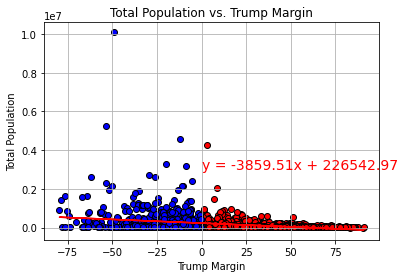

The r-value is -0.3559666517082983
The p-value is 2.0384374429323915e-93


In [25]:
# Evaluate whether "Trumpier" counties tend to have higher populations 

# Calculate linear regression model
x_values = covid_election_df["Trump Margin"]
y_values = covid_election_df["total_population"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot total population against cases per 100000 people
# Annotate with linear regression equation
plt.scatter(red_counties_df["Trump Margin"], red_counties_df["total_population"], marker="o", facecolors="red", 
            edgecolors="black")
plt.scatter(blue_counties_df["Trump Margin"], blue_counties_df["total_population"], marker="o", facecolors="blue", 
            edgecolors="black")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq, (0, 3000000), fontsize=14,color="red")
plt.grid()
plt.xlabel("Trump Margin")
plt.ylabel("Total Population")
plt.title("Total Population vs. Trump Margin")
plt.savefig("Images/Total Population vs. Trump Margin.png")
plt.show()
print(f"The r-value is {rvalue}")
print(f"The p-value is {pvalue}")
